In [1]:
#%matplotlib inline  
%pylab inline

import pandas as pd
import numpy as np


# function to get age group
def getAgeGrp( age ):
    age = int(age)
    if age <= 0:
        return np.nan
    elif age < 12:
        return 'group1'
    elif age < 18 and age >= 12:
        return 'group2'
    elif age < 30 and age >= 18 :
        return 'group3'
    else:
        return 'Adult'
    



Populating the interactive namespace from numpy and matplotlib


In [2]:
# load up labeled condition
file = '../accByKeithLabel.txt'
df =  pd.read_csv( file,sep=',',names=['subid', 'trial', 'block', 'acc', 'RT', 'age', 'lookLoc']).dropna()

# define which columns labeled
labInd = [ True]*12 + [True, True, False, False, True,True,False,False, True,True,False,False]*3
df['isLabeled'] = df.trial.apply(lambda(x):labInd[x-1] )
df['condLab'] = 1
df[ 'pracBlock'] = df[ 'block']
df.pracBlock.loc[ df.trial < 9] = 0   
dfLab =df

# load up besline condition
file = '../accByKeith.txt'
df =  pd.read_csv( file,sep=',',names=['subid', 'trial', 'block', 'acc', 'RT', 'age', 'lookLoc']).dropna()
# define which columns labeled
df['isLabeled'] = False #df.trial.apply(lambda(x):labInd[x-1] )
df['condLab'] = 0
df[ 'pracBlock'] = df[ 'block']
df.pracBlock.loc[ df.trial < 9] = 0   
# concatenate
df = pd.concat( [dfLab, df], ignore_index=True)
dfLab =df

# load up supervised condition
file = '../accByKeithSup.txt'
df =  pd.read_csv( file,sep=',',names=['subid', 'trial', 'block', 'acc', 'RT', 'age', 'lookLoc']).dropna()
# define which columns labeled
df['isLabeled'] = df.trial.apply(lambda(x):labInd[x-1] )
df['condLab'] = 2
df[ 'pracBlock'] = df[ 'block']
df.pracBlock.loc[ df.trial < 9] = 0   
# concatenate
df = pd.concat( [dfLab, df], ignore_index=True)
dfLab =df

# load up ADULT besline condition
file = '../accByKeith_AdultBL.txt'
df =  pd.read_csv( file,sep=',',names=['subid', 'trial', 'block', 'acc', 'RT', 'age', 'lookLoc']).dropna()
# define which columns labeled
df['isLabeled'] = False #df.trial.apply(lambda(x):labInd[x-1] )
df['condLab'] = 0
df[ 'pracBlock'] = df[ 'block']
df.pracBlock.loc[ df.trial < 9] = 0 
df['age'] = 24*18
# concatenate
df = pd.concat( [dfLab, df], ignore_index=True)
dfLab =df


# load up ADULT supervised condition
file = '../accByKeith_AdultSUP.txt'
df =  pd.read_csv( file,sep=',',names=['subid', 'trial', 'block', 'acc', 'RT', 'age', 'lookLoc']).dropna()
# define which columns labeled
df['isLabeled'] = df.trial.apply(lambda(x):labInd[x-1] )
df['condLab'] = 2
df[ 'pracBlock'] = df[ 'block']
df.pracBlock.loc[ df.trial < 9] = 0   
df['age'] = 24*18
# concatenate
df = pd.concat( [dfLab, df], ignore_index=True)


# clear unecessary data
del dfLab






/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [3]:

# df[df.condLab == 2]
# blockAcc

In [4]:
# get accuracy by block, add age groups  (only test trials)
blockAcc = df[ df.isLabeled == False].groupby( ['subid','pracBlock']).mean().reset_index()

blockCount = df.groupby( ['subid','pracBlock']).count() #.reset_index()
blockCount = blockCount['acc'].reset_index()


# blockCount = df.groupby( ['subid','pracBlock']).count().reset_index()  # nan dropped at loading
blockAcc[ 'count'] = blockCount['acc']

blockAcc['ageGrps'] = blockAcc.age.apply( lambda(x): getAgeGrp(x))
df['ageGrps'] = df.age.apply( lambda(x): getAgeGrp(x))

In [5]:
# find first peak and max accuracy block

def firstPeak( acc ):
    ' find first peak and index of a series'
    bPeak, aPeak = (1, acc.iloc[1])   # skip block 0 (practice)
    # loop through and find first peak
    for block,a in enumerate(acc):
        if block == 0:
            pass
        elif a > aPeak:
            bPeak = block
            aPeak = a
        elif a == aPeak:
            pass
        else:
            break            
    return bPeak, aPeak

def maxPeak( acc ):    
    'Find maximum value and index of a series'
    bMax, aMax = (1, acc.iloc[1])    # skip block 0 (practice)
    # loop through and find max accuracy
    for block,a in enumerate(acc):
        if block == 0:
            pass
        elif a > aMax:
            bMax = block
            aMax = a
    return bMax, aMax
        
#---------------------------------------------


# go through each block and find peak and max accuracy

dfToPeak = pd.DataFrame()
blockAccToPeak = pd.DataFrame()

for s in blockAcc.subid.unique():
    x = blockAcc[ blockAcc.subid == s]    
    bPeak, aPeak = firstPeak( x.acc )
    bMax, aMax = maxPeak( x.acc)    
#     print s, x.acc, bPeak, aPeak, '\n'
#     print x.acc, bMax, aMax

    # df.loc[row_indexer,column_indexer]
    blockAcc.loc[ blockAcc.subid ==s, 'peakBlock'] = bPeak
    blockAcc.loc[ blockAcc.subid ==s, 'maxBlock'] = bMax
    df.loc[ df.subid ==s, 'peakBlock'] = bPeak
    df.loc[ df.subid ==s, 'maxBlock'] = bMax
  
    dfToPeak = pd.concat( [ dfToPeak, df[(df.subid == s) &( df.pracBlock <= bPeak )]  ], ignore_index=True)
    blockAccToPeak  = pd.concat( [ blockAccToPeak, blockAcc[(blockAcc.subid == s) &( blockAcc.pracBlock <= bPeak )]  ], ignore_index=True)
# blockAcc[ blockAcc.peakBlock != 1]

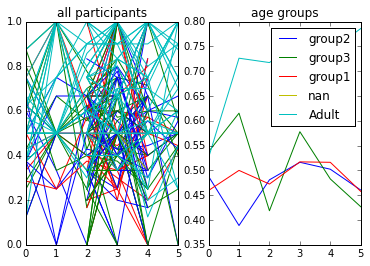

In [6]:
# show accuracy trends
gCol = { 'group1':'r-', 'group2':'b-', 'group3':'g-', 'Adult':'c-','nan':'y-'}

subplot(121)
title( 'all participants')
for s in blockAcc.subid.unique():
    sub = blockAcc[ blockAcc.subid == s]
    plot( sub.pracBlock, sub.acc, gCol[ str(sub.iloc[0].ageGrps)] )
    
subplot(122)
title( 'age groups')
for g in blockAcc.ageGrps.unique():
    sub = blockAcc[ blockAcc.ageGrps == g].groupby('pracBlock').mean().reset_index()    
    plot( sub.pracBlock, sub.acc, gCol[str(g)], label=g )
legend()    
    


In [7]:
# export to csv
blockAcc.to_csv( 'blockAccBaselineAndLabel.txt' ,sep = ',')
df.to_csv( 'trialAccBaselineAndLabel.txt' ,sep = ',')


blockAccToPeak.to_csv( 'blockAccToPeak1.txt' ,sep = '\t')
dfToPeak.to_csv( 'trialAccToPeak1.txt' ,sep = '\t')

In [8]:
# make tables to do some stats
    # get trails from the 2 highest blocks, check acc vs chance (50%)
    # ignore first block
    
labCond = 0 # 1-label; 0-baseline; 2 supervised  
grp = 'group3'



bAcc = blockAcc[(blockAcc.block >1) & (blockAcc.ageGrps == grp  ) & (blockAcc.condLab == labCond)] # skip first block, only ages >= 15
dfAfter1 = df[ (df.block > 1)& (df.age >= 15 ) & (df.condLab == labCond)]

bestBlocks = pd.DataFrame()  # to store trials from 2 best blocks
worstBlocks = pd.DataFrame() # to store trials from 2 worst blocks

# loop through participants, get 
for s in bAcc.subid.unique():
    thisSub = bAcc[ bAcc.subid == s].sort( columns='acc',ascending=False)
    
    # get good blocks
    bIdxGood = thisSub.block.iloc[0:2]  
    for b in bIdxGood:
        bestBlocks = pd.concat( [ bestBlocks,dfAfter1[ (dfAfter1.subid == s ) & ( dfAfter1.block == b) ] ], ignore_index= True)
    
    # get trials from remaining blocks
    tempBad = dfAfter1[ dfAfter1.subid == s]
    for b in bIdxGood:
        tempBad = tempBad[ tempBad.block != b]
    worstBlocks = pd.concat( [ worstBlocks,tempBad ], ignore_index= True)
    
   
 

In [9]:
# look at the best/worst and see if different from 50%

from scipy import stats

goodAcc = bestBlocks.groupby( 'subid').mean()
(t,prob) = stats.ttest_1samp(goodAcc.acc, .5 )
print 'good blocks: (t,p-val)', t,prob

badAcc = worstBlocks.groupby( 'subid').mean()
(t,prob) = stats.ttest_1samp(badAcc.acc, .5 )
print 'bad blocks: (t,p-val)', t,prob


allAcc = dfAfter1.groupby( 'subid').mean()
(t,prob) = stats.ttest_1samp(allAcc.acc, .5 )
print 'all blocks: (t,p-val)', t,prob


print 'means good, bad, all:', mean( goodAcc.acc), mean( badAcc.acc), mean( allAcc.acc)


# print thisSub.block
# bAcc

good blocks: (t,p-val) 3.32683535865 0.00603334318495
bad blocks: (t,p-val) -3.51768151889 0.00481805906791
all blocks: (t,p-val) 4.24118025297 0.000123484285103
means good, bad, all: 0.611943724292 0.370455586081 0.63530965758


In [10]:
# blockAcc
# worstBlocks
# df.ageGrps.unique()



In [11]:
# now get accuracy for a sliding window
# df.condLab.value_counts()
# df[df.ageGrps == 'Adult'] 

In [12]:
def slideAcc( acc, window=6 ):
    # return a sliding window average of accuracy 
    N = len(acc)
    wAcc = np.zeros((N))*np.nan
    for i1 in range(window,N+1):      
        a = acc.values[i1-window:i1]
        #print i1, a
        wAcc[i1-1] = nanmean(a) # get mean over window    
    return wAcc


    #figure()
    #plot( df[ df.subid ==s].trial, df[ df.subid ==s].windAcc, '.-' )
    

/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


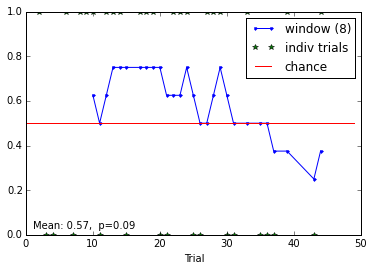

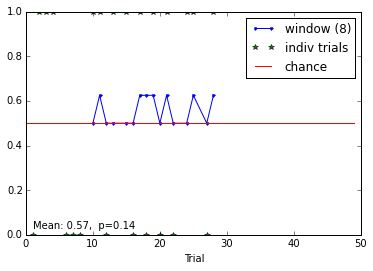

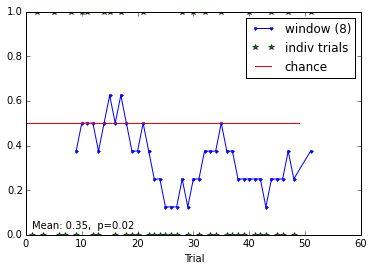

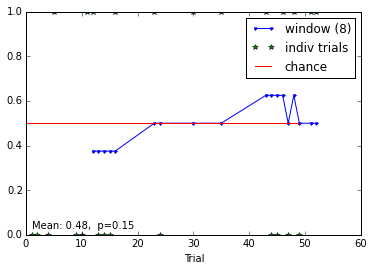

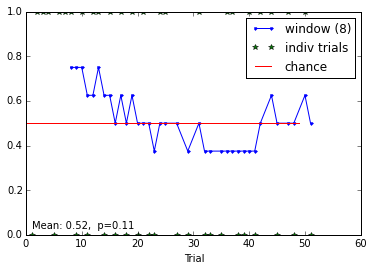

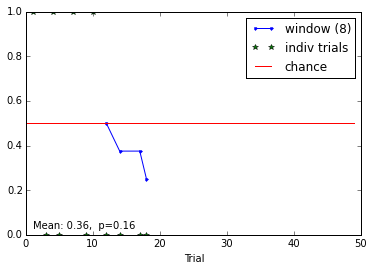

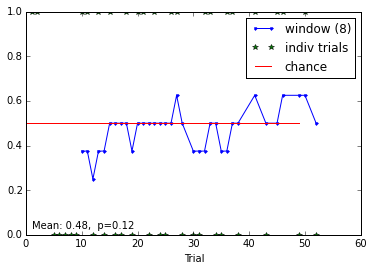

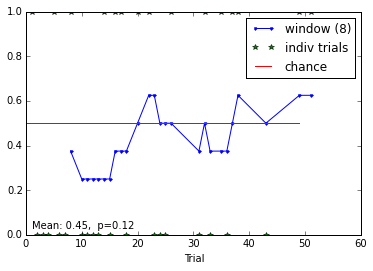

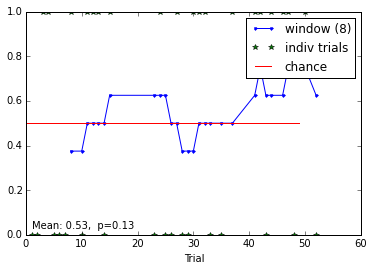

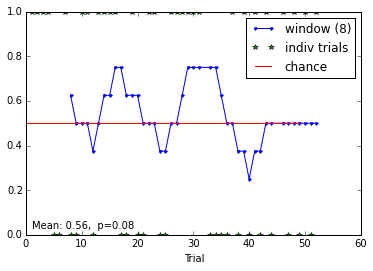

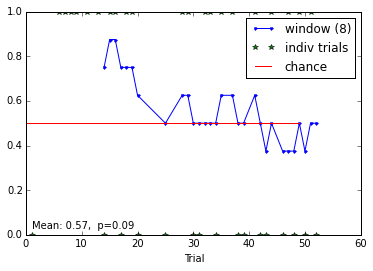

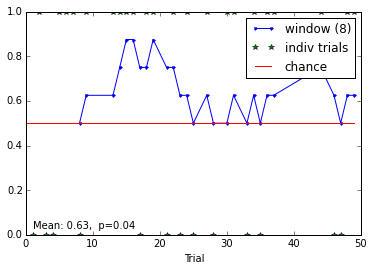

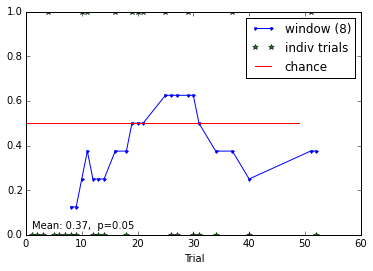

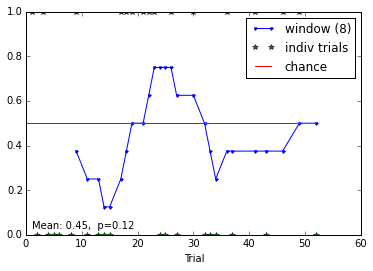

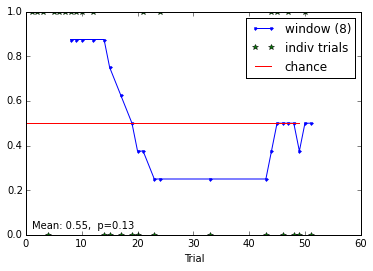

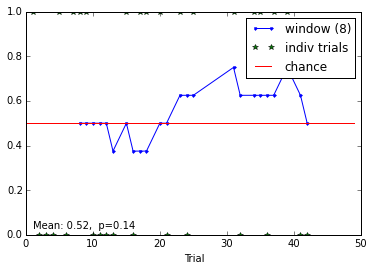

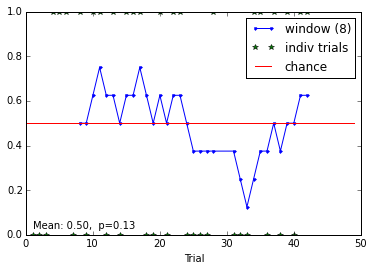

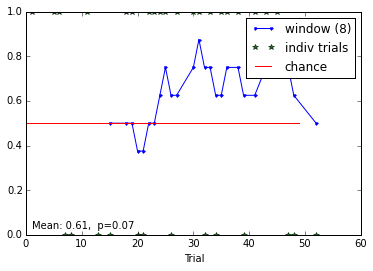

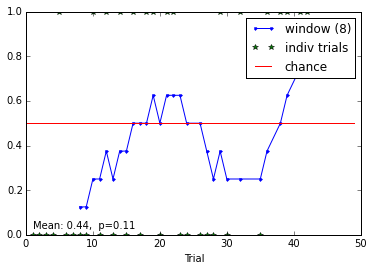

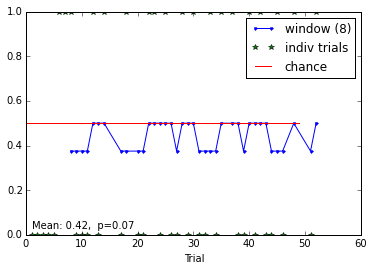

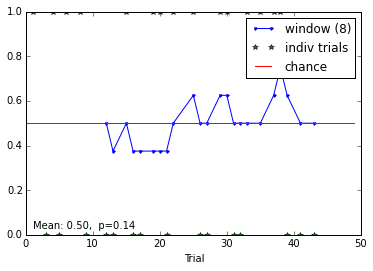

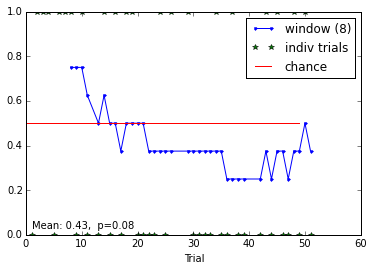

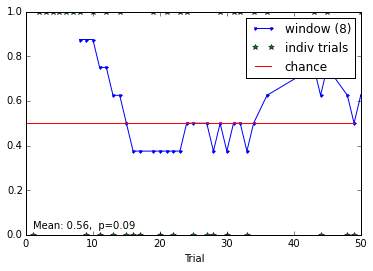

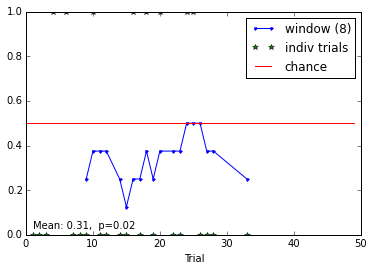

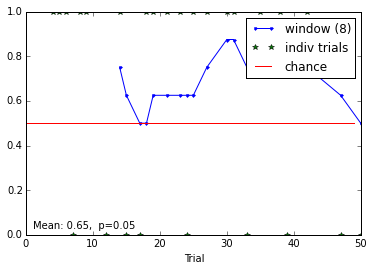

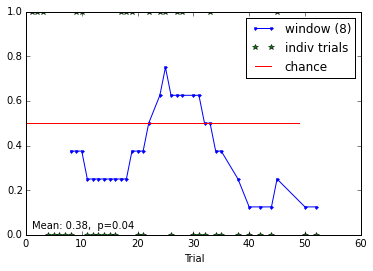

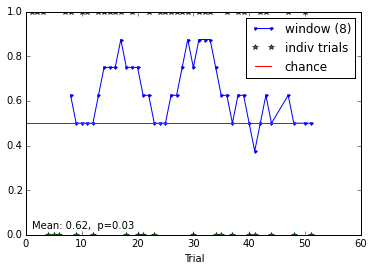

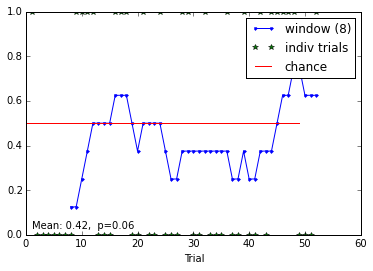

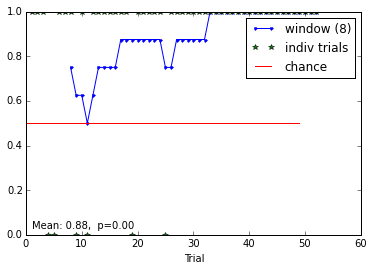

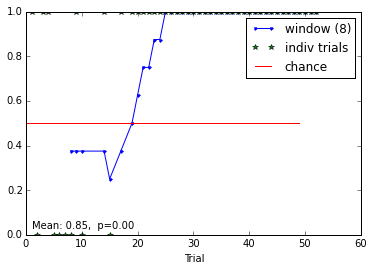

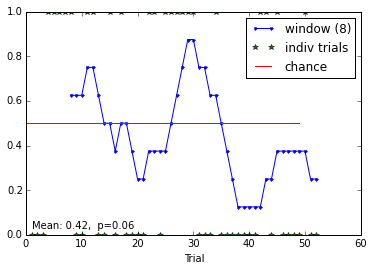

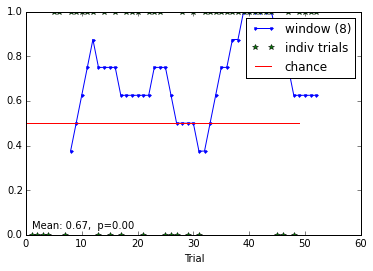

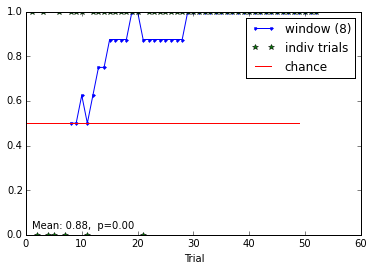

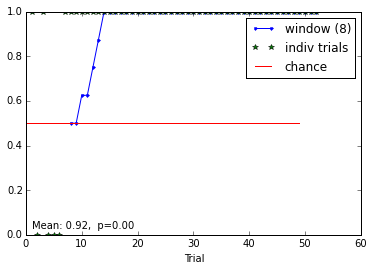

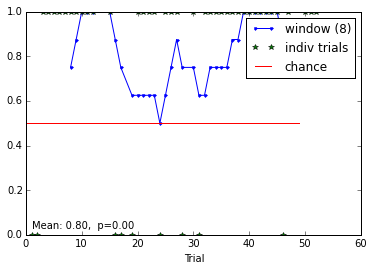

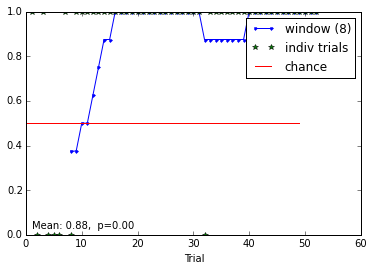

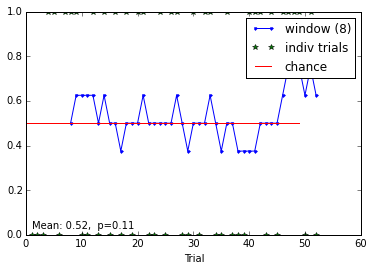

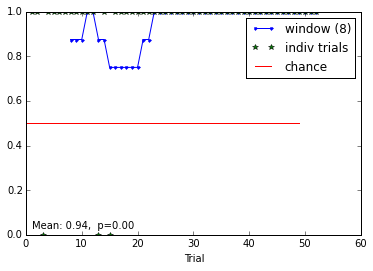

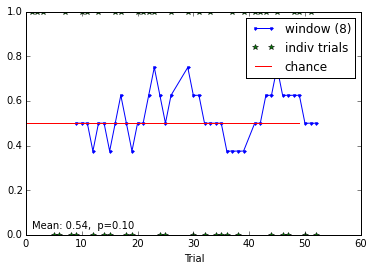

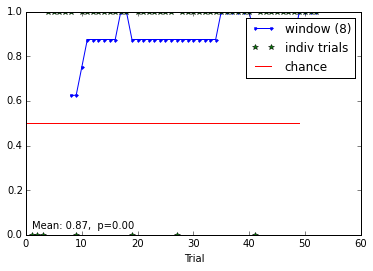

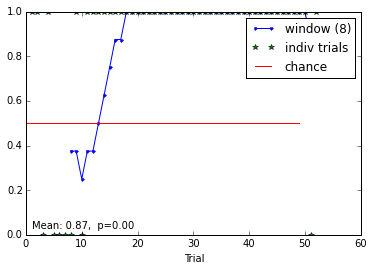

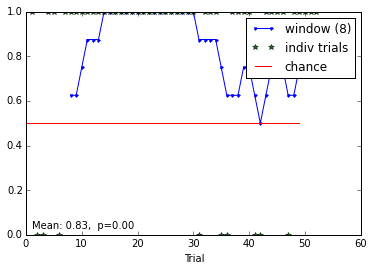

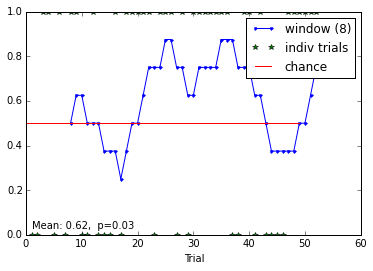

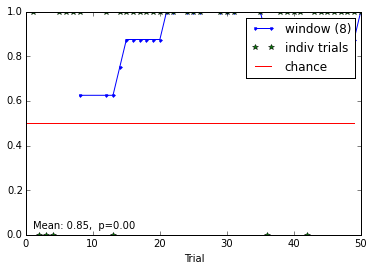

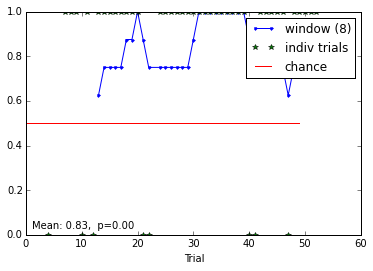

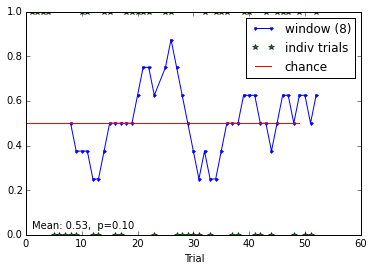

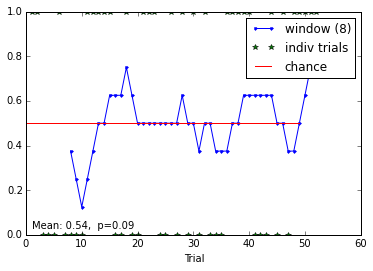

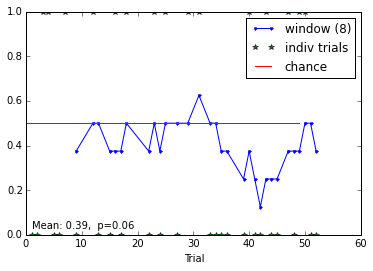

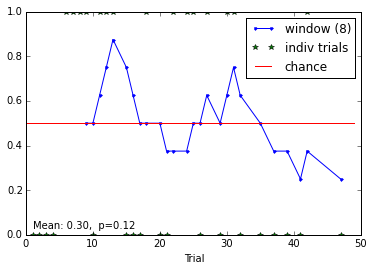

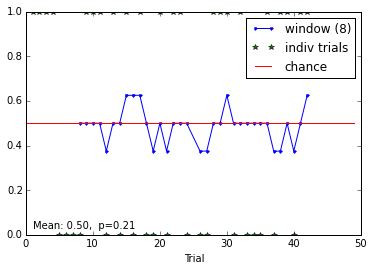

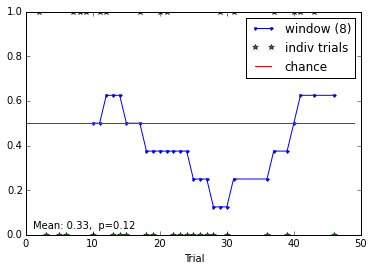

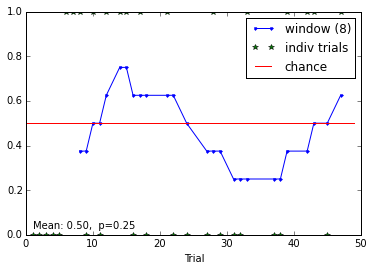

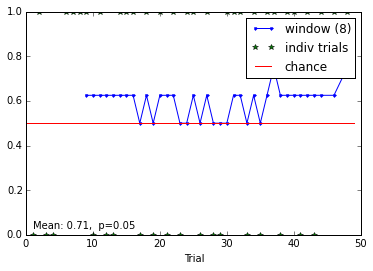

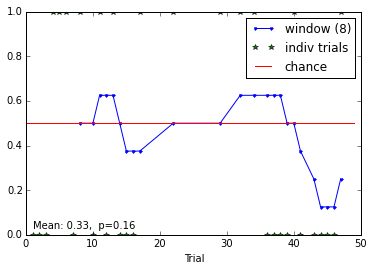

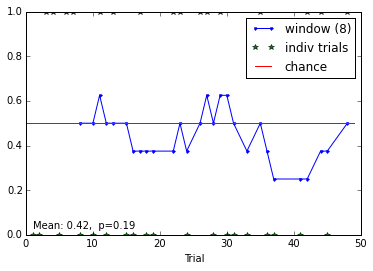

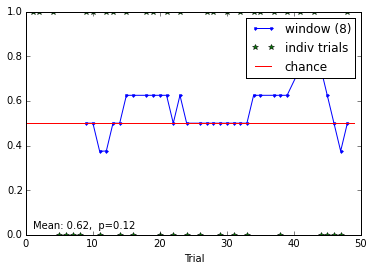

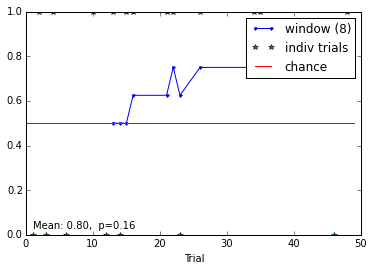

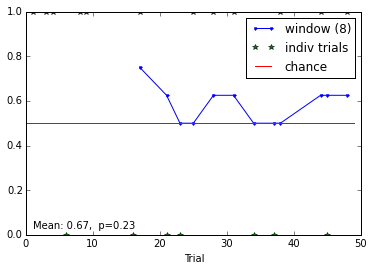

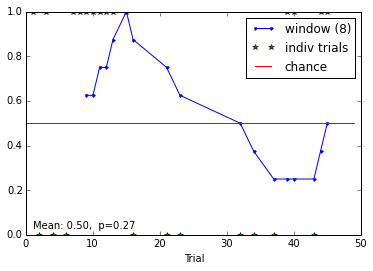

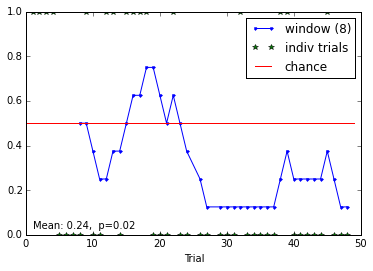

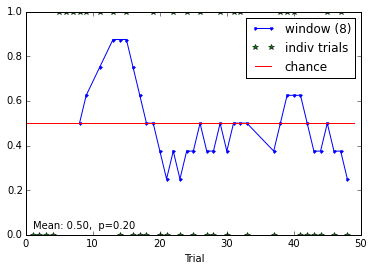

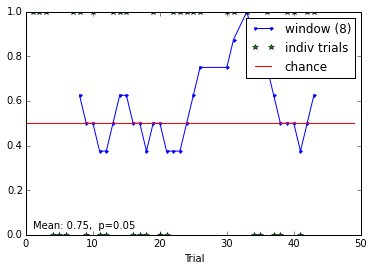

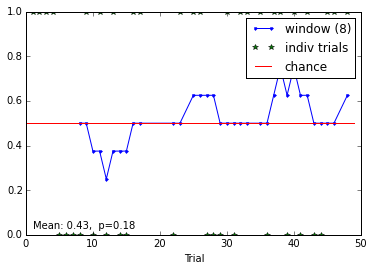

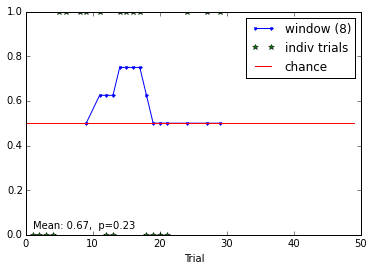

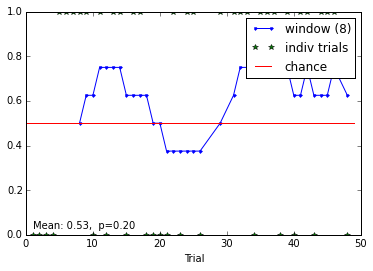

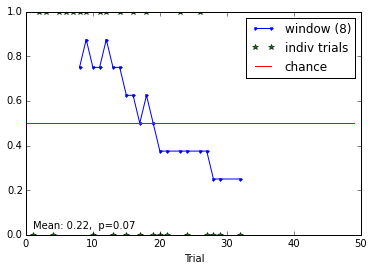

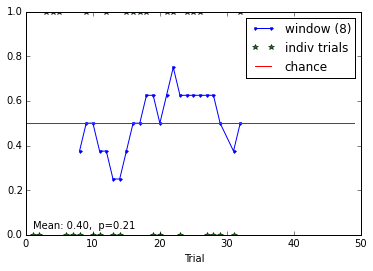

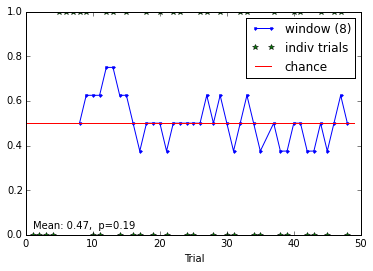

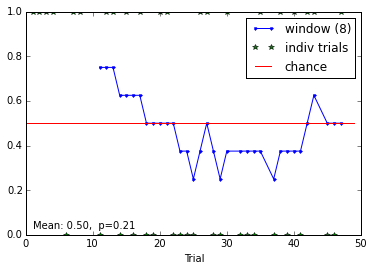

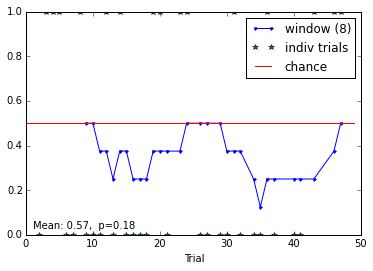

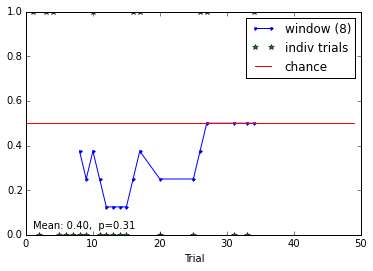

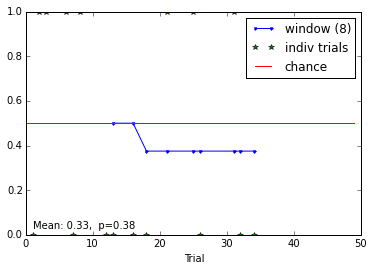

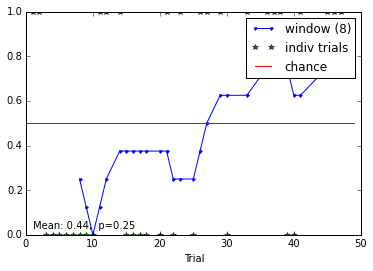

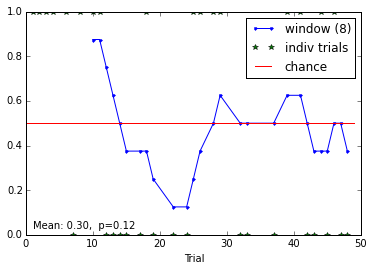

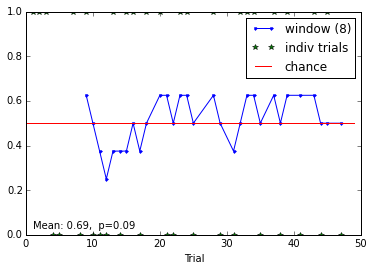

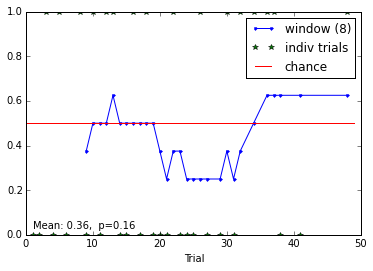

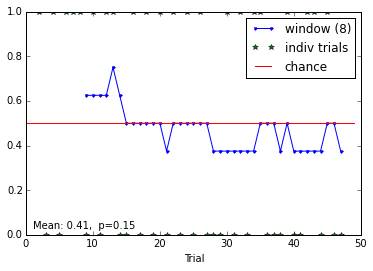

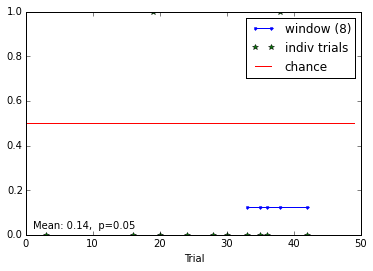

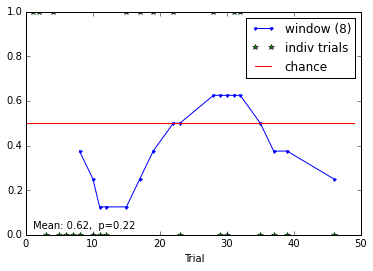

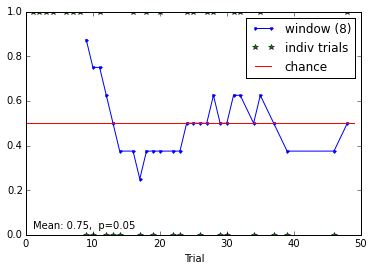

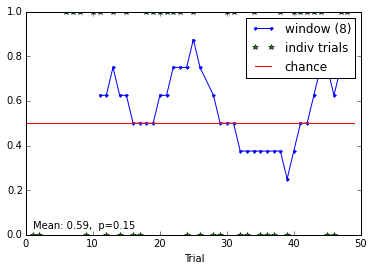

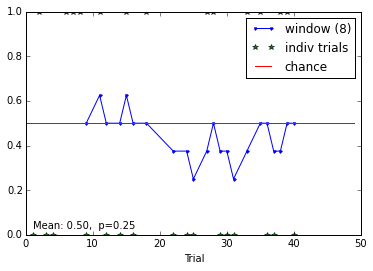

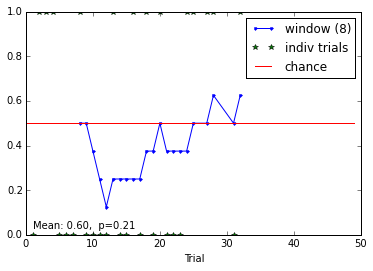

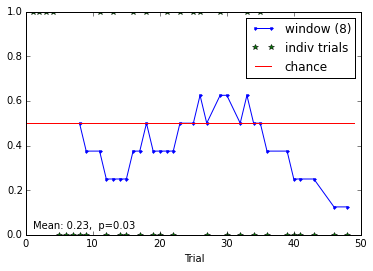

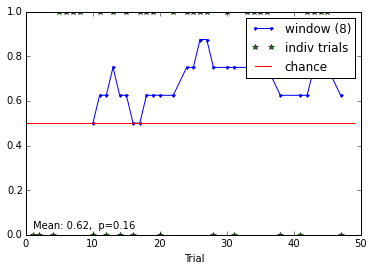

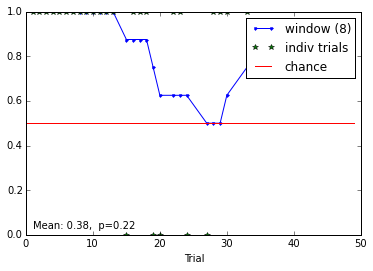

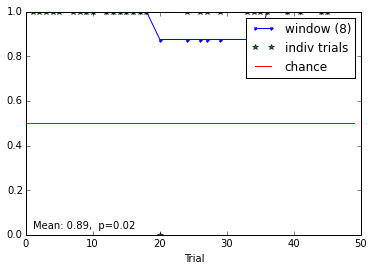

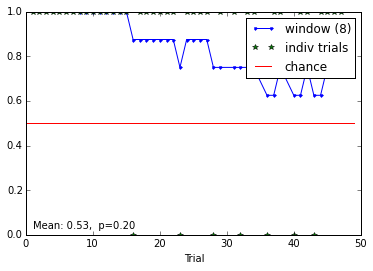

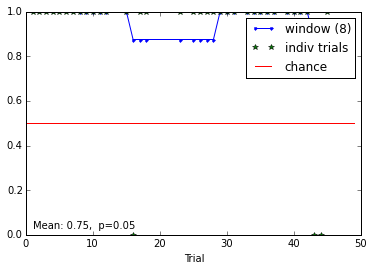

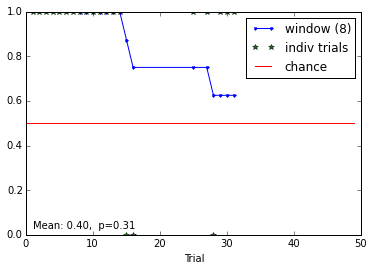

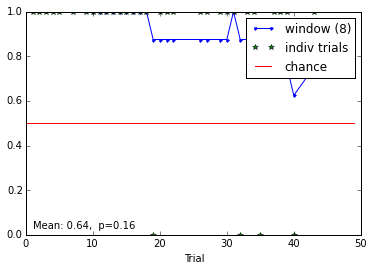

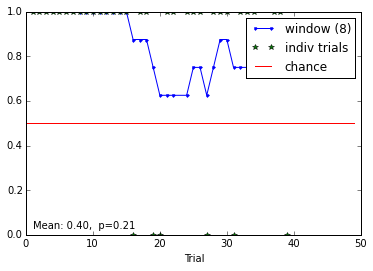

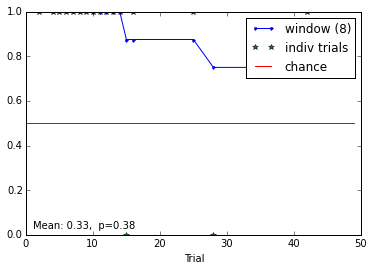

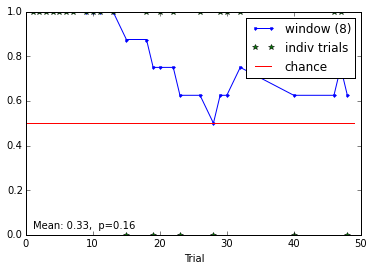

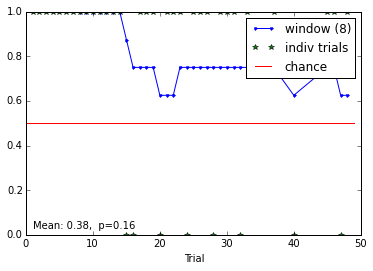

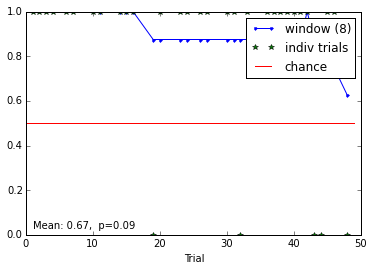

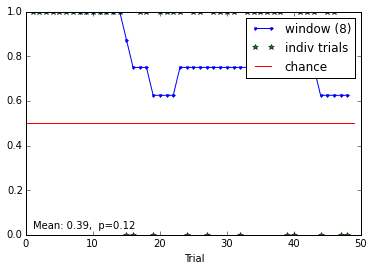

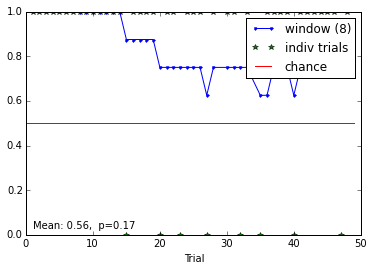

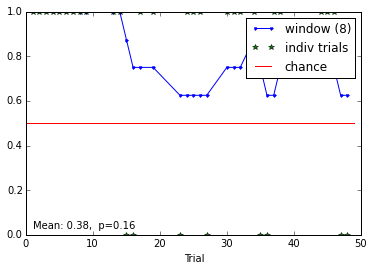

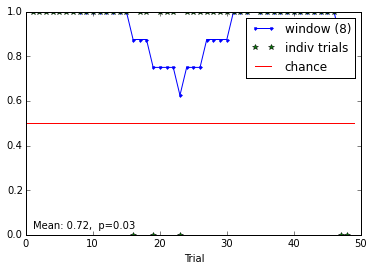

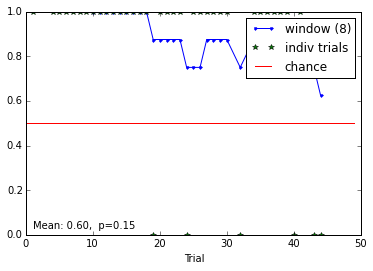

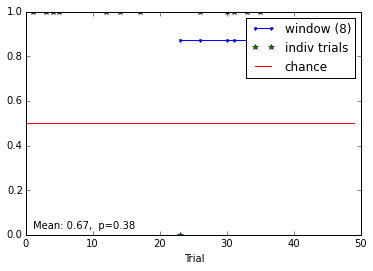

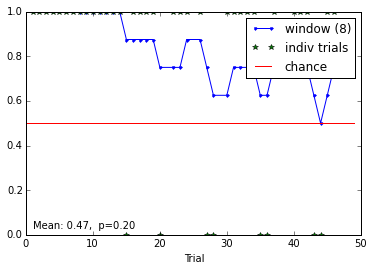

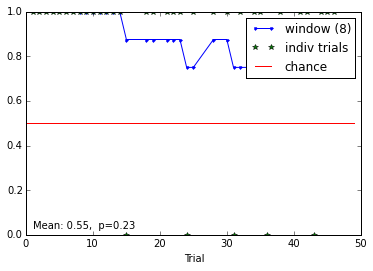

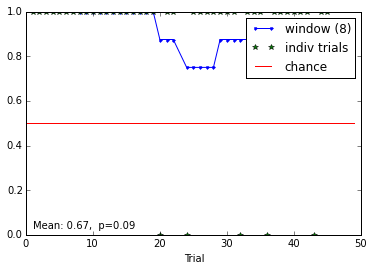

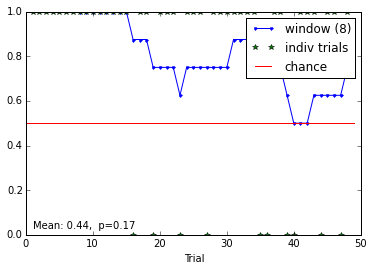

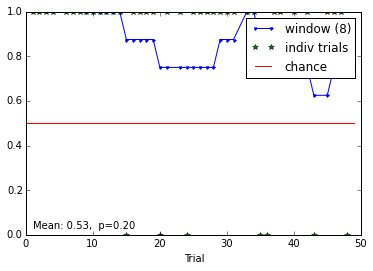

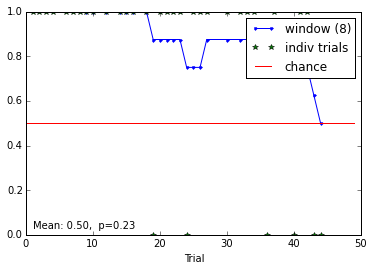

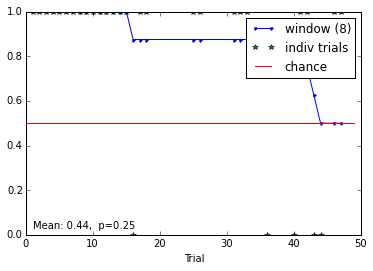

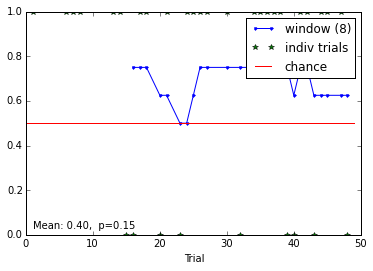

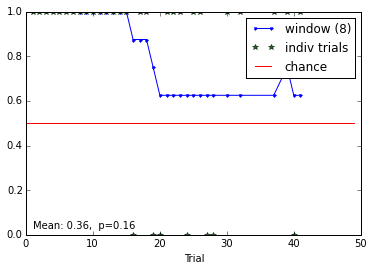

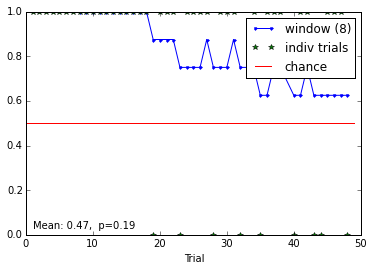

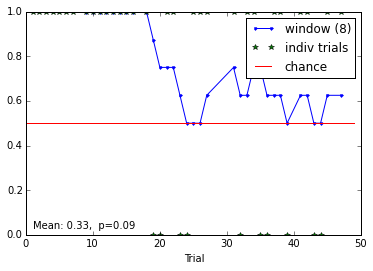

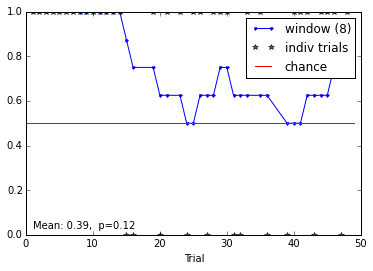

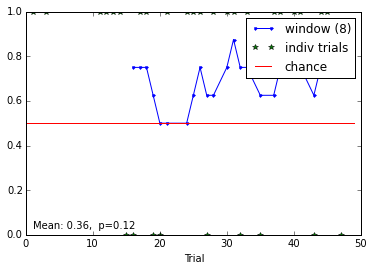

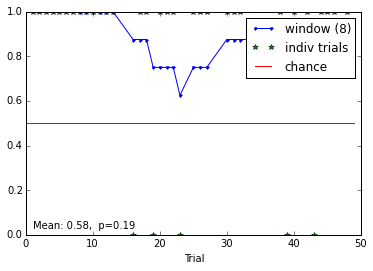

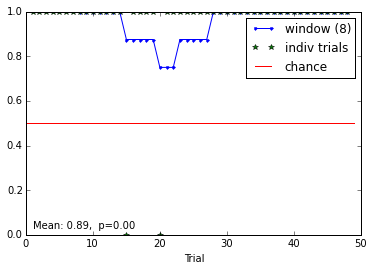

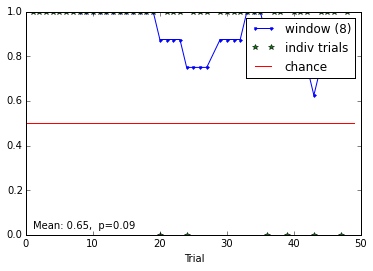

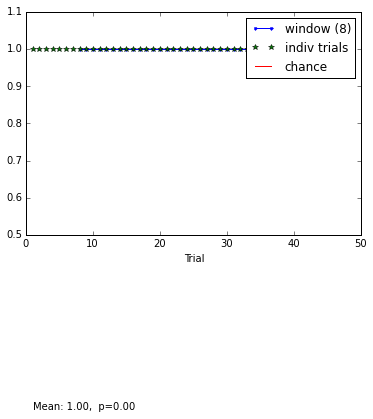

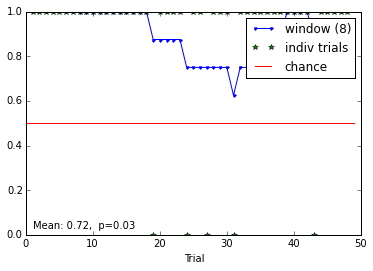

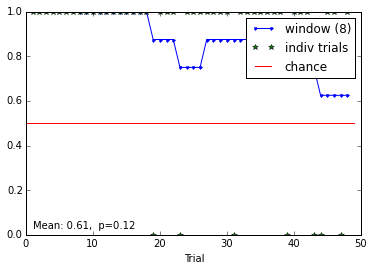

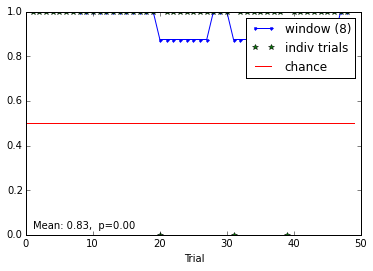

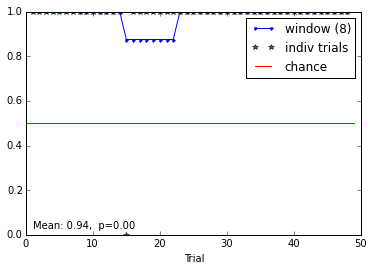

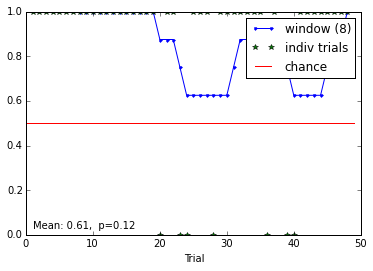

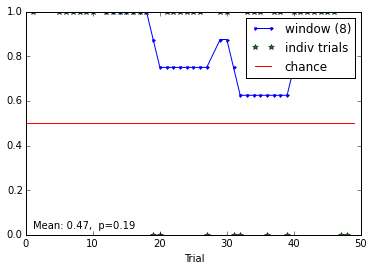

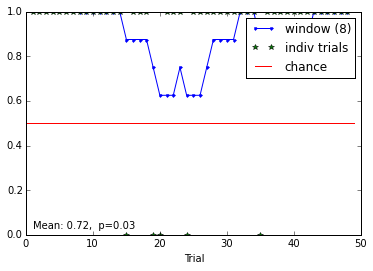

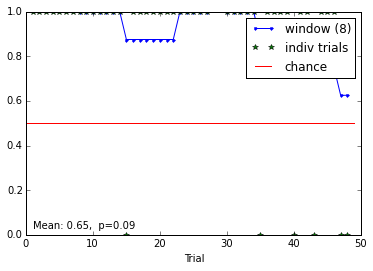

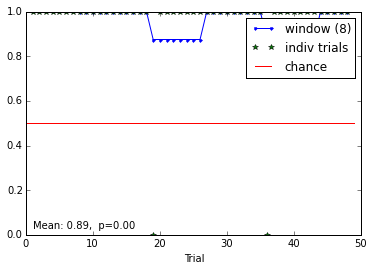

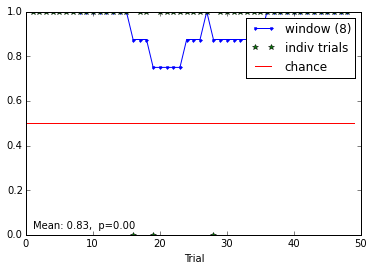

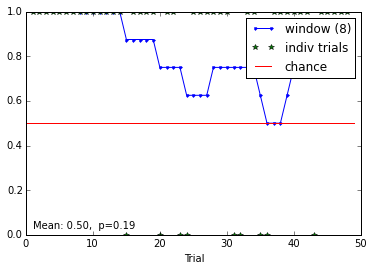

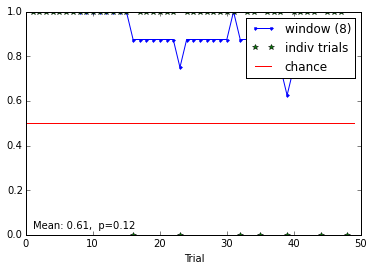

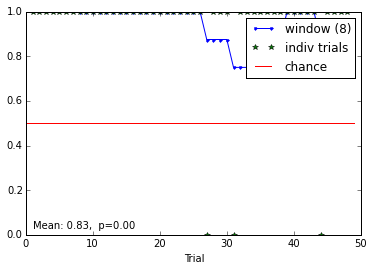

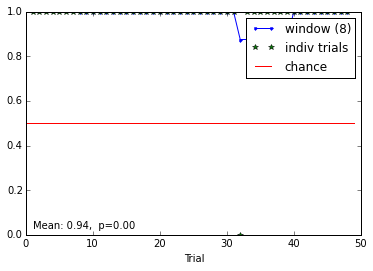

In [13]:
# go through each subject, add accuracy over sliding window

from scipy.stats import binom
import matplotlib.backends.backend_pdf as pdfOut


w = 8
df[ 'windAcc']  = np.nan
for s in df.subid.unique():
    acc = df[ df.subid ==s].acc
    df.ix[df.subid ==s, 'windAcc' ] = slideAcc( acc, window=w )
    

df['isLearner'] = np.nan
    
    
#only children    
# df = df[ df.ageGrps != 'Adult']    
    

# ageGrp = 'group3' # 'Adult' 
pList = []
mList = []
subList = []
showFig = True


#for output
#pdf = pdfOut.PdfPages( 'curves%sCond%d.pdf'%(ageGrp, cond))


# show learning curves for some condition 
for cond in [0,1,2]:
    
    # for s in df[df.condLab == cond].subid.unique():   
    for s in df[(df.condLab == cond) ].subid.unique():    #& (df.ageGrps == ageGrp)

        a = df[ (df.subid ==s) & (df.isLabeled== False)  ].acc
        x, n = sum(a), len(a)
        pVal = binom.pmf(x, n, .5)
        
        # add learning status to dataframe
        if (nanmean(a) > .5) and (pVal < 0.05):
            learned=1
        else:
            learned=0
        df.ix[df.subid==s,'isLearner'] = learned
        df.ix[df.subid==s,'pVal'] = pVal

        # Plot
        if showFig:
            fig = figure()   
            plot( df[ df.subid ==s].trial, df[ df.subid ==s].windAcc, 'b.-', label='window (%d)'%w )
            plot( df[ df.subid ==s].trial, df[ df.subid ==s].acc, 'g*', label ='indiv trials' )       
            plot( np.arange(0,50),[.5]*50, 'r-', label='chance')  # chance line    
            text(1, .03,  'Mean: %.2f,  p=%.02f' % (mean(a) ,pVal) )
            xlabel('Trial')
            legend()       
            #pdf.savefig( fig )

        if len( a ) > 15:   #(at least 20 trials)  
            subList.append(s)
            pList.append(pVal)
            mList.append( mean(a))        

# save DF            
df.to_csv( 'trialAccAllAndLrnCrit.txt' ,sep = ',', index=False)    

# pd.save( df, 'dfBehavKARSAll.p')
pd.to_pickle(df, 'dfBehavKARSAll.p')




In [14]:
# pList = np.concatenate( (np.array(pList), np.array( mList)), axis=0)
pList = np.array( pList)
mList = np.array( mList)
subList = np.array(subList)


lrnSubs = subList[  (pList <.1) & (mList > .5)]
lrnPs = pList[ (pList <.1) & (mList > .5)]
nLrnPs = pList[ (pList <.1) & (mList < .5)]

# display things
print( '%d out of %d learned' % ( len(lrnPs),len(pList)))
print lrnSubs
print( '%d out of %d anti-learned' % ( len(nLrnPs),len(pList)))




38 out of 77 learned
[4749 4770 4773 4776 4792 4801 4803 4809 6378 6474 6519 6523 6528 6530 8055
 8060 8108 8109 8113 8114 8115 8116 8117 8399 4836 5070 6669 6670 6671 6672
 6880 6881 6891 8401 8402 8529 8537 8538]
10 out of 77 anti-learned


In [15]:
# anonymize
'''
count = 0
for s in df.subid.unique():
    count+= 1
    df.ix[df.subid==s ,'subid'] = ('sub%d'% count)
    
df.to_csv( 'KARS_Anon.txt', sep=',', index=False)
'''

"\ncount = 0\nfor s in df.subid.unique():\n    count+= 1\n    df.ix[df.subid==s ,'subid'] = ('sub%d'% count)\n    \ndf.to_csv( 'KARS_Anon.txt', sep=',', index=False)\n"

In [16]:
# summarize which participants learned
dfLearner = df[df.isLabeled == False].groupby('subid', as_index=False).mean()
dfLearner.drop(['trial','block', 'isLabeled', 'pracBlock', 'windAcc'], axis=1, inplace=True )
dfLearner.to_csv( 'subLrnSummary.txt' ,sep = ',', index=False)  
dfLearner

,subid,acc,RT,age,lookLoc,condLab,peakBlock,maxBlock,isLearner,pVal
0,4749,0.571429,3537.420000,16,1.657143,0,1,1,0,9.452759e-02
1,4750,0.565217,4965.491304,24,1.869565,0,1,3,0,1.363833e-01
2,4756,0.354167,3007.292917,8,1.500000,0,1,1,0,1.507921e-02
3,4757,0.480000,3009.071200,22,1.160000,0,1,4,0,1.549810e-01
4,4758,0.522727,3343.209091,16,1.340909,0,1,1,0,1.144040e-01
5,4759,0.363636,3304.169091,12,1.454545,0,1,1,0,1.611328e-01
6,4761,0.476190,3233.647619,8,1.023810,0,1,4,0,1.168227e-01
7,4765,0.454545,3770.631818,16,1.393939,0,2,5,0,1.207411e-01
8,4768,0.527778,3521.574722,16,1.777778,0,1,1,0,1.251100e-01
9,4770,0.560000,3322.914000,16,1.400000,0,3,3,0,7.882567e-02


In [17]:
# define some function for individual accuracy fitting

import statsmodels.api as sm
import statsmodels.formula.api as smf


def binarize( yHat ):
    yBin = np.ones( yHat.shape)
    yBin[ yHat < .5] = 0
    return yBin


def fitAndShow( modelSpec, df ):
    # do the model fitting and visualization
    # modelSpec: 'isLearner ~ age + recepPercentile + prodPercentile'

    # fit model and give output
    logMod = smf.logit( modelSpec, data = df )
    logitRes = logMod.fit()  
    print logitRes.summary()     # show the stats

    # error rates
    # yBin  = binarize(yHat) #get binary decision rule
    # print(metrics.classification_report(y, yBin))
    # print(metrics.confusion_matrix(y, yBin))

    # estimate Y  and plot
    yHat=  logMod.predict(logitRes.params)  
    
    xHat = np.dot(logMod.exog, logitRes.params)   
#     xHat = logMod.exog[:,-1]
    
    
    figure()
    plot(xHat, yHat, '*',color='blue', label='estimate' )
    plot( xHat, logMod.endog, 'go', label='true') # plot true
    legend()


Optimization terminated successfully.
         Current function value: 0.659493
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                    acc   No. Observations:                   35
Model:                          Logit   Df Residuals:                       33
Method:                           MLE   Df Model:                            1
Date:                Sun, 17 Jan 2016   Pseudo R-squ.:               0.0003313
Time:                        12:43:56   Log-Likelihood:                -23.082
converged:                       True   LL-Null:                       -23.090
                                        LLR p-value:                    0.9016
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.4570      0.658      0.695      0.487        -0.832     1.746
trial          0.0030      0.

PerfectSeparationError: Perfect separation detected, results not available

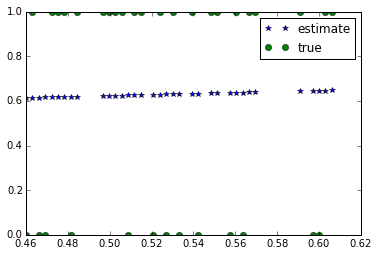

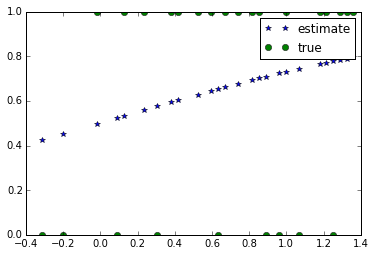

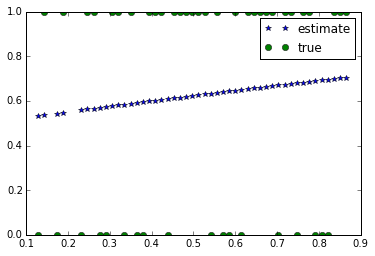

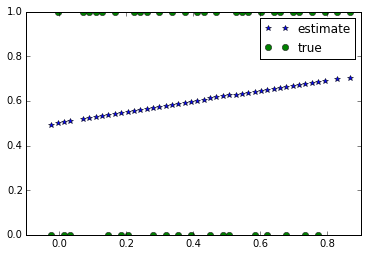

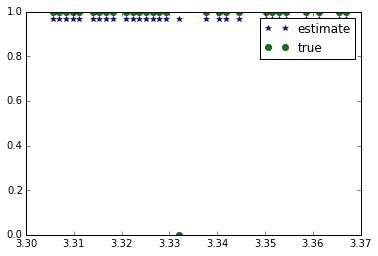

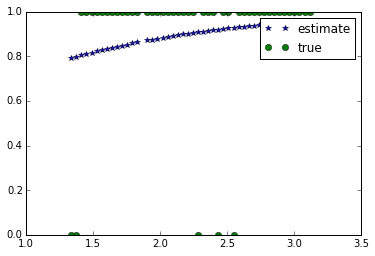

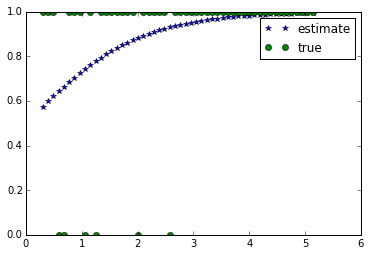

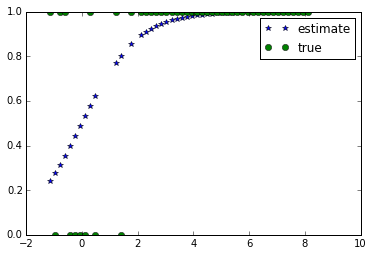

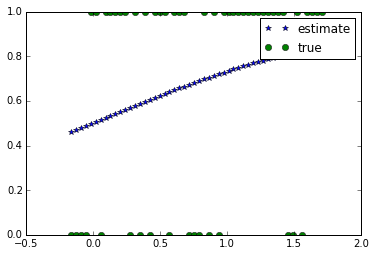

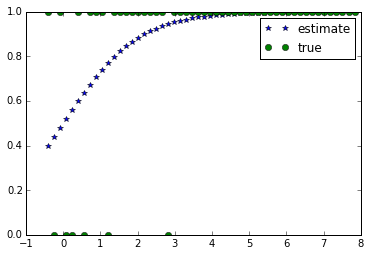

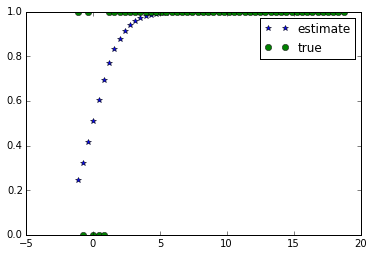

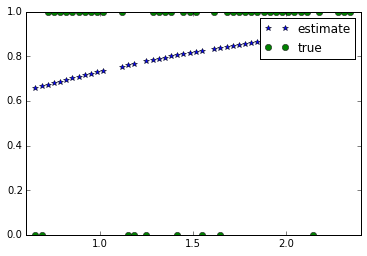

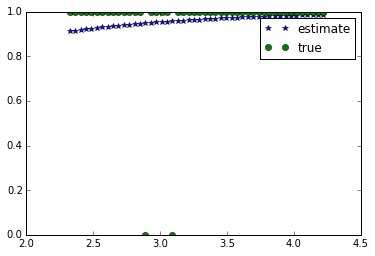

In [19]:
# fit learning curves (logistic function to accuracy data)

for s in dfLearner[dfLearner.isLearner == 1].subid.unique():
    fitAndShow( 'acc ~ trial', df[df.subid == s] ) 



In [23]:
dfLearner.columns

Index([u'subid', u'acc', u'RT', u'age', u'lookLoc', u'condLab', u'peakBlock',
       u'maxBlock', u'isLearner', u'pVal'],
      dtype='object')

In [24]:
# now let us run some stats.  Note that these measures contain adults
# blockAcc
# df
# dfLearner


dfLrnOldChild = dfLearner[(dfLearner.age < 40) & (dfLearner.age >11)]

lsMod = smf.ols( 'maxBlock ~ C(condLab )' , data=dfLrnOldChild).fit()
print( lsMod.summary())




                            OLS Regression Results                            
Dep. Variable:               maxBlock   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     17.16
Date:                Sun, 17 Jan 2016   Prob (F-statistic):           8.93e-07
Time:                        12:44:45   Log-Likelihood:                -90.792
No. Observations:                  72   AIC:                             187.6
Df Residuals:                      69   BIC:                             194.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept             2.5455      0.18

In [25]:
# print lsMod.params
binMod = smf.glm( 'isLearner ~ C( condLab)', data=dfLrnOldChild, family=sm.families.Binomial()).fit()
print binMod.summary()

                 Generalized Linear Model Regression Results                  
Dep. Variable:              isLearner   No. Observations:                   72
Model:                            GLM   Df Residuals:                       69
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -16.040
Date:                Sun, 17 Jan 2016   Deviance:                       32.081
Time:                        12:44:46   Pearson chi2:                     51.0
No. Iterations:                    24                                         
                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept            -1.8458      0.621     -2.971      0.003        -3.063    -0.628
C(condLab)[T.1.0]   -23.7202   

In [26]:
dfLrnOldChild.groupby('condLab').mean()

,subid,acc,RT,age,lookLoc,peakBlock,maxBlock,isLearner,pVal
condLab,,,,,,,,,
0,4780.818182,0.507832,3537.748134,19.136364,1.454652,1.636364,2.545455,0.136364,0.096405
1,4872.809524,0.474787,3676.449783,15.952381,1.502037,1.285714,1.285714,0.000000,0.182797
2,5070.827586,0.507218,3433.256815,18.172414,1.506695,1.206897,1.206897,0.068966,0.172665


(array([  22.,    0.,    1.,    5.,    9.,   29.,   36.,    2.,   39.,
           0.,  107.,   43.,    3.,   47.,    2.,   33.,   16.,    2.,
          12.,    0.,   84.]),
 array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
         0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
         0.9 ,  0.95,  1.  ,  1.05]),
 <a list of 21 Patch objects>)

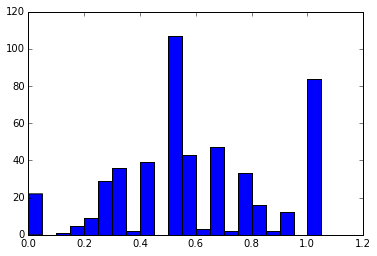

In [27]:
hist( blockAcc[ blockAcc.pracBlock > 0].acc.values, bins=np.arange(0,1.1,.05) )

In [28]:
df

,subid,trial,block,acc,RT,age,lookLoc,isLabeled,condLab,pracBlock,ageGrps,peakBlock,maxBlock,windAcc,isLearner,pVal
0,4828,1,1,0,3339.70,18,1,True,1,0,group3,1,1,NaN,0,0.117188
1,4828,2,1,0,3640.10,18,1,True,1,0,group3,1,1,NaN,0,0.117188
2,4828,3,1,0,3344.40,18,1,True,1,0,group3,1,1,NaN,0,0.117188
3,4828,4,1,0,3299.80,18,1,True,1,0,group3,1,1,NaN,0,0.117188
4,4828,6,1,1,3092.40,18,1,True,1,0,group3,1,1,NaN,0,0.117188
5,4828,7,1,1,4850.80,18,1,True,1,0,group3,1,1,NaN,0,0.117188
6,4828,8,1,1,3599.10,18,1,True,1,0,group3,1,1,NaN,0,0.117188
7,4828,9,1,1,3672.70,18,1,True,1,1,group3,1,1,0.500,0,0.117188
8,4828,10,1,0,3080.20,18,1,True,1,1,group3,1,1,0.500,0,0.117188
9,4828,11,1,1,4856.60,18,2,True,1,1,group3,1,1,0.625,0,0.117188


In [29]:
# blockAcc
# df
# dfLearner

# STATS FOR MEETING
dfLrnOldChild = dfLearner[(dfLearner.age < 40) & (dfLearner.age >11) ]

dfLearner.groupby('condLab').isLearner.value_counts()

condLab   
0        0    31
         1    17
1        0    36
         1     1
2        0    36
         1    12
dtype: int64

In [30]:
df2Blocks = df[ (df.pracBlock >0) & ( df.pracBlock <= 2) & (df.ageGrps != 'Adult')& (df.age > 11) ] 
df2Blocks.groupby(['ageGrps', 'condLab', 'isLabeled']).mean() #.reset_index()[['condLab','ageGrps', 'isLabeled', 'acc', 'RT']]

subid      trial     block       acc  \
ageGrps condLab isLabeled                                               
group2  0       False      4772.747475  15.212121  1.686869  0.505051   
        1       False      4869.355932  19.118644  2.000000  0.474576   
                True       4869.178218  14.287129  1.564356  0.465347   
        2       False      5060.534247  19.493151  2.000000  0.493151   
                True       5059.731481  14.518519  1.601852  1.000000   
group3  0       False      4787.986111  15.527778  1.729167  0.527778   
        1       False      4872.818182  19.151515  2.000000  0.333333   
                True       4869.833333  14.814815  1.592593  0.537037   
        2       False      5085.924242  18.833333  2.000000  0.469697   
                True       5081.683333  13.908333  1.533333  1.000000   

                                    RT        age   lookLoc  pracBlock  \
ageGrps condLab isLabeled                                                
group2  0       False      3443.657273  15.505051  1.313131   1.686869   
        1       False      3599.769492  12.762712  1.474576   2.000000   
                True       3407.627624  12.861386  1.564356   1.564356   
        2       False      3227.661644  13.684932  1.465753   2.000000   
                True       3088.493611  13.666667  1.490741   1.601852   
group3  0       False      3804.277708  21.652778  1.486111   1.729167   
        1       False      3682.306061  19.393939  1.696970   2.000000   
                True       3868.833333  19.333333  1.648148   1.592593   
        2       False      3310.017727  21.833333  1.560606   2.000000   
                True       3201.379167  21.900000  1.525000   1.533333   

                           peakBlock  maxBlock   windAcc  isLearner      pVal  
ageGrps condLab isLabeled                                                      
group2  0       False       1.747475  2.787879  0.497368   0.000000  0.107833  
        1       False       1.305085  1.305085  0.506356   0.000000  0.161034  
                True        1.336634  1.336634  0.498762   0.000000  0.169477  
        2       False       1.164384  1.164384  0.795139   0.082192  0.157274  
                True        1.185185  1.185185  0.919471   0.092593  0.162388  
group3  0       False       1.638889  2.513889  0.526460   0.222222  0.083268  
        1       False       1.303030  1.303030  0.477679   0.000000  0.168128  
                True        1.277778  1.277778  0.507212   0.000000  0.185077  
        2       False       1.303030  1.303030  0.826923   0.060606  0.159696  
                True        1.283333  1.283333  0.954955   0.058333  0.172063

In [31]:
df2BlocksNoLab = df2Blocks[df2Blocks.isLabeled == False]
binMod = smf.glm( 'acc ~ C( condLab)*age', data=df2BlocksNoLab, family=sm.families.Binomial()).fit()
print binMod.summary()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    acc   No. Observations:                  474
Model:                            GLM   Df Residuals:                      468
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -326.63
Date:                Sun, 17 Jan 2016   Deviance:                       653.27
Time:                        12:44:50   Pearson chi2:                     474.
No. Iterations:                     6                                         
                          coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept              -0.1503      0.691     -0.218      0.828        -1.504     1.203
C(condLab)[T.1]         0

In [32]:
lsMod = smf.ols( 'RT ~ C(condLab )' , data=df2BlocksNoLab).fit()
print( lsMod.summary())

                            OLS Regression Results                            
Dep. Variable:                     RT   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     4.729
Date:                Sun, 17 Jan 2016   Prob (F-statistic):            0.00926
Time:                        12:44:50   Log-Likelihood:                -4045.9
No. Observations:                 474   AIC:                             8098.
Df Residuals:                     471   BIC:                             8110.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept        3657.3583     79.310     

In [33]:
# go through each subject, add accuracy over sliding window (making sure eliminate labeled trials)

# get sliding window accuracy for each participant
dfNoLab = df[ (df.isLabeled == False) & (df.ageGrps != 'Adult') ] 

w = 6
dfNoLab[ 'windAcc']  = np.nan
dfNoLab['peakUpDownSum'] = np.nan
dfNoLab['peakMax'] = np.nan
dfNoLab['peakMin'] = np.nan


for s in dfNoLab.subid.unique():
    acc = dfNoLab[ dfNoLab.subid ==s].acc
    sAcc = slideAcc( acc, window=w )
    
    dfNoLab.ix[dfNoLab.subid ==s, 'windAcc' ] = sAcc
    dfNoLab.ix[dfNoLab.subid ==s, 'peakUpDownSum' ] = nanmax(sAcc) + nanmin(sAcc) 
    dfNoLab.ix[dfNoLab.subid ==s, 'peakMax' ] = nanmax(sAcc) 
    dfNoLab.ix[dfNoLab.subid ==s, 'peakMin' ] = nanmin(sAcc) 
    
#     plot( sAcc, '-')

dfNoLab.acc.value_counts()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-

0    887
1    877
dtype: int64

In [34]:
dfNoLabPeakSum = dfNoLab.groupby('subid', as_index=False).head(1)[['subid', 'peakUpDownSum', 'age', 'condLab', 'peakMax', 'peakMin']].reset_index()
dfNoLabPeakSum


,index,subid,peakUpDownSum,age,condLab,peakMax,peakMin
0,12,4828,0.833333,18,1,0.500000,0.333333
1,47,4830,1.000000,18,1,0.666667,0.333333
2,86,4831,0.666667,8,1,0.500000,0.166667
3,122,4833,0.833333,16,1,0.666667,0.166667
4,155,4836,1.333333,8,1,0.833333,0.500000
5,200,4842,0.666667,8,1,0.333333,0.333333
6,230,4844,0.833333,19,1,0.500000,0.333333
7,266,4845,1.333333,13,1,0.833333,0.500000
8,304,4846,NaN,8,1,NaN,NaN
9,320,4848,1.333333,23,1,0.666667,0.666667


In [35]:

lsMod = smf.ols( 'peakUpDownSum ~ C(condLab )' , data=dfNoLabPeakSum).fit()
print( lsMod.summary())

                            OLS Regression Results                            
Dep. Variable:          peakUpDownSum   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.021
Method:                 Least Squares   F-statistic:                   0.09062
Date:                Sun, 17 Jan 2016   Prob (F-statistic):              0.913
Time:                        12:45:26   Log-Likelihood:                -19.442
No. Observations:                  89   AIC:                             44.88
Df Residuals:                      86   BIC:                             52.35
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           1.0062      0.059     

(0, 1)

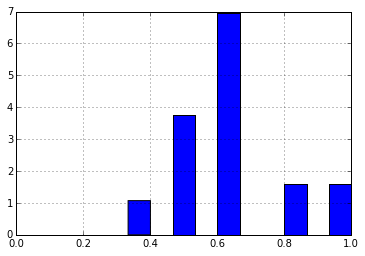

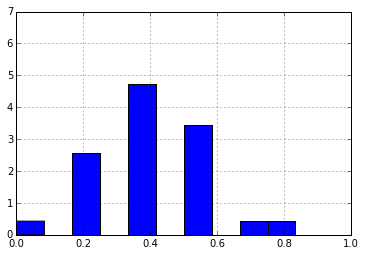

In [36]:
dfNoLabPeakSum[dfNoLabPeakSum.condLab ==2].peakMax.hist(normed=True)
ylim([0,7])
xlim([0,1])
figure()
dfNoLabPeakSum[dfNoLabPeakSum.condLab ==2].peakMin.hist(normed=True)
ylim([0,7])
xlim([0,1])


In [37]:
nanmean( dfNoLabPeakSum[dfNoLabPeakSum.condLab ==2].peakUpDownSum )

1.0178571428571428

(0, 7)

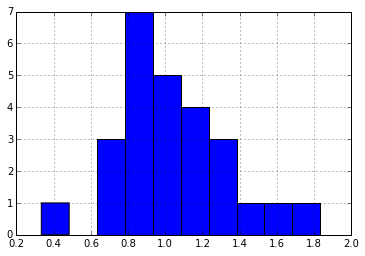

In [38]:
dfNoLabPeakSum[dfNoLabPeakSum.condLab ==2].peakUpDownSum.hist(normed=False)
ylim([0,7])
# xlim([0,1])


In [39]:
dfNoLab = df[ (df.isLabeled == False) & (df.ageGrps != 'Adult') ] 
firstHalf = dfNoLab[ (dfNoLab.trial > 8 ) & (dfNoLab.trial <28 )] 
secHalf = dfNoLab[ (dfNoLab.trial > 27 ) ] 

In [40]:
# firstHalf.groupby(['condLab', 'ageGrps']).mean()
firstHalf = firstHalf.groupby(['subid', 'condLab', 'ageGrps']).mean().reset_index() #.std()
secHalf = secHalf.groupby(['subid','condLab', 'ageGrps']).mean().reset_index()

In [41]:
firstHalf.groupby(['condLab', 'ageGrps']).mean()

subid      trial     block       acc           RT  \
condLab ageGrps                                                            
0       group1   4776.000000  17.384568  2.000350  0.466282  3368.046748   
        group2   4772.444444  17.487961  1.999566  0.451311  3553.022881   
        group3   4786.615385  17.877702  2.053107  0.535818  3733.503291   
1       group1   4879.187500  19.925744  2.112946  0.465476  3367.887783   
        group2   4870.083333  20.132937  2.147817  0.469246  3607.204821   
        group3   4876.444444  19.487566  2.075132  0.305026  3736.875661   
2       group2   5061.538462  20.543040  2.137363  0.489011  3241.641850   
        group3   5078.375000  19.801488  2.139435  0.492560  3506.382586   

                       age   lookLoc isLabeled  pracBlock  peakBlock  \
condLab ageGrps                                                        
0       group1    8.200000  1.509770     False   2.000350   1.600000   
        group2   15.333333  1.343538     False   1.999566   1.666667   
        group3   21.769231  1.449011     False   2.053107   1.615385   
1       group1    8.625000  1.396726     False   2.112946   1.500000   
        group2   12.833333  1.478175     False   2.147817   1.333333   
        group3   20.111111  1.633333     False   2.075132   1.222222   
2       group2   13.692308  1.450549     False   2.137363   1.153846   
        group3   21.812500  1.636905     False   2.139435   1.250000   

                 maxBlock   windAcc  isLearner      pVal  
condLab ageGrps                                           
0       group1   2.200000  0.484821   0.000000  0.077763  
        group2   2.666667  0.489034   0.000000  0.112761  
        group3   2.461538  0.532911   0.230769  0.085082  
1       group1   1.500000  0.484338   0.062500  0.146747  
        group2   1.333333  0.504216   0.000000  0.180135  
        group3   1.222222  0.472917   0.000000  0.186347  
2       group2   1.153846  0.784226   0.076923  0.159578  
        group3   1.250000  0.828069   0.062500  0.183297

In [42]:
secHalf.groupby(['condLab', 'ageGrps']).mean()

subid      trial     block       acc           RT  \
condLab ageGrps                                                            
0       group1   4776.000000  36.840463  3.933630  0.377956  3417.647511   
        group2   4774.125000  37.754819  3.980300  0.541326  3392.761828   
        group3   4786.615385  38.577002  4.084434  0.528137  3629.927841   
1       group1   4879.187500  37.718960  3.493218  0.541978  3687.674719   
        group2   4871.000000  35.877056  3.398557  0.478211  3275.917496   
        group3   4876.444444  35.703968  3.317989  0.485714  4041.933466   
2       group2   5061.538462  36.811244  3.443640  0.533605  3125.381535   
        group3   5078.375000  36.682005  3.435976  0.510254  3811.823001   

                       age   lookLoc isLabeled  pracBlock  peakBlock  \
condLab ageGrps                                                        
0       group1    8.200000  1.689542     False   3.933630   1.600000   
        group2   15.750000  1.486452     False   3.980300   1.750000   
        group3   21.769231  1.490958     False   4.084434   1.615385   
1       group1    8.625000  1.478019     False   3.493218   1.500000   
        group2   12.909091  1.530592     False   3.398557   1.363636   
        group3   20.111111  1.489683     False   3.317989   1.222222   
2       group2   13.692308  1.374972     False   3.443640   1.153846   
        group3   21.812500  1.553102     False   3.435976   1.250000   

                 maxBlock   windAcc  isLearner      pVal  
condLab ageGrps                                           
0       group1   2.200000  0.446762   0.000000  0.077763  
        group2   2.875000  0.497354   0.000000  0.106715  
        group3   2.461538  0.519338   0.230769  0.085082  
1       group1   1.500000  0.523736   0.062500  0.146747  
        group2   1.363636  0.425830   0.000000  0.175204  
        group3   1.222222  0.479101   0.000000  0.186347  
2       group2   1.153846  0.732465   0.076923  0.159578  
        group3   1.250000  0.755466   0.062500  0.183297

In [22]:
# key things looking at
#     unlabeled, infants, after block 1

dfNoLabOnlyCorrect = df[ (df.isLabeled == False) & (df.ageGrps != 'Adult') & (df.pracBlock > 1) & (df.acc == 1) ]  
dfCorrect= dfNoLabOnlyCorrect.groupby(['ageGrps', 'condLab']).mean()
dfCorrect # the mean for different conditions, only correct test trials

dfNoLab = df[ (df.isLabeled == False) & (df.ageGrps != 'Adult') & (df.pracBlock > 1) ]  
noLabMean = dfNoLab.groupby(['ageGrps', 'condLab']).mean() #.to_csv('vladSummary.txt', sep='\t' )
noLabMean # the mean for different conditions, ALL test trials

subid      trial     block       acc           RT  \
ageGrps condLab                                                            
group1  0        4770.813433  29.783582  3.253731  0.447761  3291.515896   
        1        4880.995122  30.024390  2.897561  0.497561  3493.257220   
group2  0        4773.633929  29.857143  3.254464  0.513393  3440.233661   
        1        4867.263158  28.488722  2.796992  0.503759  3500.192406   
        2        5063.635870  29.815217  2.869565  0.505435  3172.470293   
group3  0        4790.164557  29.718354  3.256329  0.509494  3698.865918   
        1        4873.554217  29.036145  2.807229  0.445783  3804.883133   
        2        5086.715084  30.055866  2.916201  0.513966  3465.419737   

                       age   lookLoc isLabeled  pracBlock  peakBlock  \
ageGrps condLab                                                        
group1  0         8.231343  1.574627     False   3.253731   1.395522   
        1         8.653659  1.429268     False   2.897561   1.580488   
group2  0        15.691964  1.388393     False   3.254464   1.790179   
        1        12.902256  1.511278     False   2.796992   1.330827   
        2        13.581522  1.402174     False   2.869565   1.179348   
group3  0        21.373418  1.449367     False   3.256329   1.680380   
        1        19.433735  1.602410     False   2.807229   1.301205   
        2        21.798883  1.547486     False   2.916201   1.324022   

                 maxBlock   windAcc  isLearner      pVal  
ageGrps condLab                                           
group1  0        2.111940  0.453008   0.000000  0.076184  
        1        1.580488  0.500610   0.082927  0.143531  
group2  0        2.790179  0.506696   0.000000  0.104037  
        1        1.330827  0.455827   0.000000  0.160738  
        2        1.179348  0.770492   0.097826  0.152138  
group3  0        2.512658  0.520238   0.256329  0.079319  
        1        1.301205  0.508117   0.000000  0.172327  
        2        1.324022  0.777388   0.050279  0.155589

In [ ]:
print('Mean accuracy and so on (test trials only)')
print noLabMean[['trial', 'acc', 'RT', 'age']]

print( '\n\nNumber of trials in calculation')
print dfNoLab.groupby(['ageGrps', 'condLab']).count()['trial']

print( '\n\nRT only correct trials')
print dfCorrect[['acc','RT']]

print( '\n\nNumber of trials in RT calculation')
print dfNoLabOnlyCorrect.groupby(['ageGrps', 'condLab']).count()['trial']


In [ ]:
# dfNoLabOnlyCorrect.groupby(['ageGrps', 'condLab']).head(20)

In [ ]:
# dfNoLab : 
# 

dfNoLab.groupby(['ageGrps', 'condLab','subid']).mean().tail(100) #.to_csv('vladSummaryBySub.txt', sep='\t' )

In [ ]:
dfNoLabOnlyCorrect